In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from collections import OrderedDict
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import time

import datetime
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from torch.optim.lr_scheduler import CosineAnnealingLR,ReduceLROnPlateau


In [2]:
!pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.2 MB/s eta 0:00:00


In [3]:
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score

# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) # get loss
    
    if(opt is not None):
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss

def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred)) 
    acc = accuracy_score(y_test,y_pred_tag.detach().numpy())
    acc = round(100*acc)
    return acc

def recall(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred)) 
    get_recall = recall_score(y_test,y_pred_tag.detach().numpy())
    get_recall = round(100*get_recall)
    return get_recall

def precision(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred)) 
    get_precision = precision_score(y_test,y_pred_tag.detach().numpy())
    get_precision = round(100*get_precision)
    return get_precision

def f1(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    get_f1 = f1_score(y_test,y_pred_tag.detach().numpy())
    get_f1 = round(100*get_f1)
    return get_f1

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,eval_funcs,opt=None):
    
    run_loss=0.0
    
    t_metric = {}; metric = {}
    for i in eval_funcs:
        t_metric[i] = 0.0
        
    # internal loop over dataset
    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        y_pred  = model(xb)
        
        loss = loss_batch(loss_func,y_pred, yb.unsqueeze(1),opt=opt)
        
        for feval in eval_funcs:
            if(feval == 'accuracy'):
                t_metric[feval] += accuracy(y_pred, yb.unsqueeze(1))
            if(feval == 'f1'):
                t_metric[feval] += f1(y_pred,yb.unsqueeze(1))
            if(feval == 'recall'):
                t_metric[feval] += recall(y_pred,yb.unsqueeze(1))
        
        run_loss += loss.item()
    loss=run_loss/len(dataset_dl)  # average loss value
    
    for feval in eval_funcs:
        temp = t_metric[feval]/len(dataset_dl)
        metric[feval] = temp  # average metric value
        
    
    return loss, metric

# Training Function
def train_val(model, params,verbose=False):
    
    t0 = time.time()
    
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    eval_funcs = params['eval_func'] # list of evaluation functions
    write_metric = params['write_metric']
    
    loss_history={"train": [],"val": []} # history of loss values in each epoch
    best_model_wts = copy.deepcopy(model.state_dict()) # a deep copy of weights for the best performing model
    best_loss=float('inf') # initialize best loss to a large value
    
    tr_dict_eval = {}; te_dict_eval = {}
    for evals in eval_funcs:
        tr_dict_eval[evals] = []
        te_dict_eval[evals] = []
    
    for epoch in range(epochs):
        
        current_lr=get_lr(opt)
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,eval_funcs,opt)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl,eval_funcs)
        
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), weight_path)
                
        loss_history["train"].append(train_loss)
        loss_history["val"].append(val_loss)
        
        for evals in eval_funcs:
            tr_dict_eval[evals].append(train_metric[evals])
            te_dict_eval[evals].append(val_metric[evals])
        
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Saving best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"epoch: {epoch+1+0:03} | train loss: {train_loss:.3f} | val loss: {val_loss:.3f} | train-{write_metric}: {train_metric[write_metric]:.3f} val-{write_metric}: {val_metric[write_metric]:.3f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    t1 = time.time()
    print(f'Total Time: {t1-t0:.3f}')
        
    return model, loss_history, {'train':tr_dict_eval,'val':te_dict_eval}

In [4]:
import pandas as pd

df = pd.read_csv('../input/lower-back-pain-symptoms-dataset/Dataset_spine.csv')
df.drop([df.columns[-1]],axis=1,inplace=True)

df['Class_att'] = df['Class_att'].astype('category')
encode_map = {
    'Abnormal': 1,
    'Normal': 0
}

df['Class_att'].replace(encode_map, inplace=True)
df['Class_att'].value_counts()

1    210
0    100
Name: Class_att, dtype: int64

In [5]:
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,1


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

y = df['Class_att']
X = df.drop(['Class_att'],axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.20,
                                                  random_state=13,
                                                  shuffle=True)
print(f'X_train: {X_train.shape}')
print(f'X_val: {X_val.shape}')

X_train: (248, 12)
X_val: (62, 12)


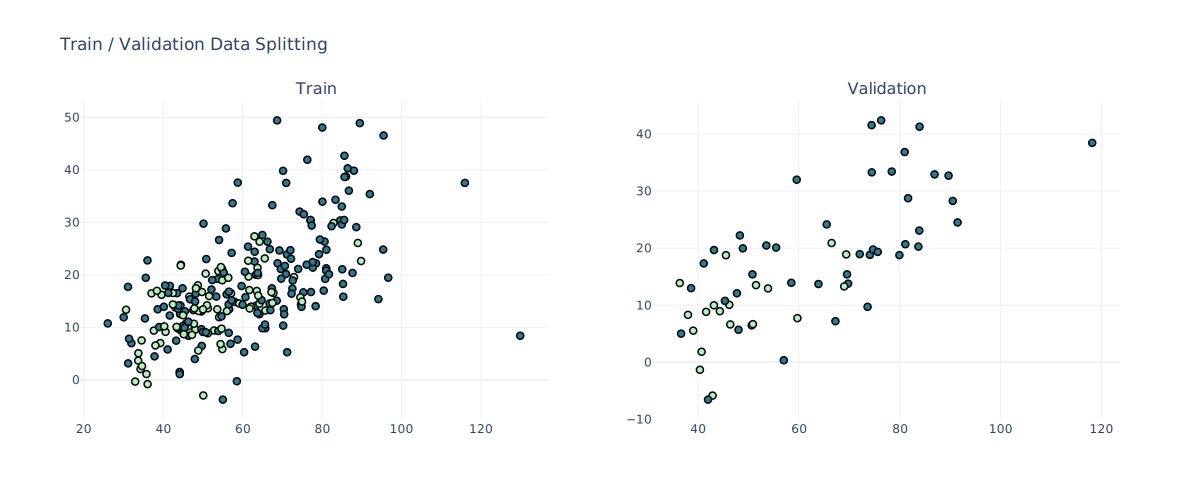

In [7]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2,subplot_titles=['Train','Validation'])
itrace = px.scatter(x=X_train['Col1'],
                    y=X_train['Col2'],
                    color=y_train,
                   )['data'][0]
trace = px.scatter(x=X_val['Col1'],
                   y=X_val['Col2'],
                   color=y_val,
                  )['data'][0]

fig.add_trace(itrace, row=1, col=1)
fig.add_trace(trace, row=1, col=2)

fig.update_layout(template='plotly_white',
                  title='Train / Validation Data Splitting',
                  font=dict(family='sans-serif',size=12),
                  width=1200)

fig.update_traces({'marker_line_width':1.5, 
                   'marker_line_color':"black",
                   'marker_size':7,
                   'opacity':1.0,
                  })

fig.update_layout(showlegend=True)
fig.update_coloraxes(colorscale="tealgrn")
fig.update_layout(coloraxis_showscale=False)
fig.update_layout(showlegend=True)
fig.show(renderer="svg")

In [8]:
X_train = X_train.values
X_val = X_val.values
y_train = y_train.values
y_val = y_val.values

sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

In [9]:
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)
y_train_tensor = torch.FloatTensor(y_train)
y_val_tensor = torch.FloatTensor(y_val)

# Builds dataset containing ALL data points
train_dataset = TensorDataset(X_train_tensor,
                              y_train_tensor)
val_dataset = TensorDataset(X_val_tensor,
                            y_val_tensor)

# Builds a loader of each set
batch_size = 16
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size, 
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=batch_size)

In [10]:
for x,y in train_loader:
    print(x.shape,y)
    break

torch.Size([16, 12]) tensor([1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1.])


In [11]:
class BinaryClassification(nn.Module):
    
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(12, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = BinaryClassification()
opt = optim.Adam(model.parameters(), lr=1e-4)
loss = nn.BCEWithLogitsLoss()

# Create Parameter Dictionary
params_train={
  "train": train_loader,
    "val": val_loader,
 "epochs": 200,
 "optimiser": opt,
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,verbose=0),
 "f_loss": loss,
 "weight_path": "weights.pt",
 "eval_func" : ['accuracy','f1','recall','precision'],
 "write_metric" : 'f1'
}

nn_model,loss_hist,metric_hist=train_val(model,params_train,verbose=True)
epochs=params_train["epochs"]

epoch: 001 | train loss: 0.736 | val loss: 0.685 | train-f1: 54.625 val-f1: 50.250
epoch: 002 | train loss: 0.711 | val loss: 0.662 | train-f1: 58.500 val-f1: 55.000
epoch: 003 | train loss: 0.688 | val loss: 0.642 | train-f1: 60.688 val-f1: 59.250
epoch: 004 | train loss: 0.660 | val loss: 0.632 | train-f1: 67.375 val-f1: 59.000
epoch: 005 | train loss: 0.662 | val loss: 0.615 | train-f1: 65.875 val-f1: 62.250
epoch: 006 | train loss: 0.638 | val loss: 0.594 | train-f1: 66.250 val-f1: 67.750
epoch: 007 | train loss: 0.631 | val loss: 0.585 | train-f1: 67.000 val-f1: 70.250
epoch: 008 | train loss: 0.614 | val loss: 0.577 | train-f1: 71.375 val-f1: 70.250
epoch: 009 | train loss: 0.594 | val loss: 0.572 | train-f1: 71.312 val-f1: 71.250
epoch: 010 | train loss: 0.595 | val loss: 0.561 | train-f1: 70.125 val-f1: 75.250
epoch: 011 | train loss: 0.592 | val loss: 0.545 | train-f1: 73.625 val-f1: 77.500
epoch: 012 | train loss: 0.572 | val loss: 0.546 | train-f1: 73.688 val-f1: 76.250
epoc

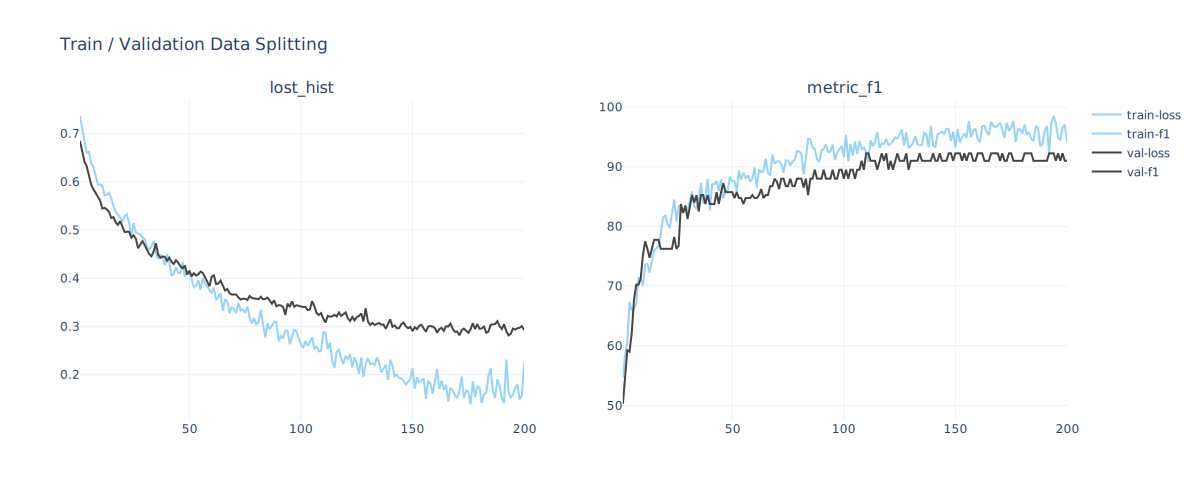

In [12]:
def plot_res(metric_hist,name):
    
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=['lost_hist',f'metric_{name}'])

    # Training Data 

    fig.add_trace(go.Scatter(x=[*range(1,epochs+1)],
                             y=loss_hist["train"],
                              line=dict(color="#94D4F6",width=2),
                             name='train-loss'),row=1, col=1)
    fig.add_trace(go.Scatter(x=[*range(1,epochs+1)],
                             y=metric_hist["train"][name],
                             line=dict(color="#94D4F6",width=2),
                             name=f'train-{name}'),row=1, col=2)

    # Validation Data

    fig.add_trace(go.Scatter(x=[*range(1,epochs+1)],
                             y=loss_hist["val"],
                             line=dict(color="#454545",width=2),
                             name='val-loss'),row=1, col=1)
    fig.add_trace(go.Scatter(x=[*range(1,epochs+1)],
                             y=metric_hist["val"][name],
                             line=dict(color="#454545",width=2),
                             name=f'val-{name}'),row=1, col=2)

    fig.update_layout(template='plotly_white',
                      title='Train / Validation Data Splitting',
                      font=dict(family='sans-serif',size=12),
                      width=1200)

    fig.update_traces({'marker_line_width':3, 
                       'marker_line_color':"black",
                       'marker_size':8,
                       'opacity':1.0,
                       'marker':{'showscale':True,'reversescale':True, 'cmid':0, 'size':10},
                      })

    fig.update_coloraxes(colorscale="tealgrn")
    fig.update_layout(coloraxis_showscale=False)
    fig.show(renderer='svg')
    
plot_res(metric_hist,'f1')

In [13]:
X_test, y_test = val_dataset[:10]

model.eval()
logits = nn_model(X_test.to(device))
probs = torch.sigmoid(logits)
probs

threshold = .5
confusion_matrix(y_test[:10], (probs.cpu() >= threshold))

array([[4, 0],
       [0, 6]])